In [1]:
import tensorflow as tf 
import numpy as np 
import time
import os
from matplotlib import pyplot as plt
from tensorflow.keras import layers
import importlib
import nifty5 as ift

import parameters as p

from steps import training_steps

from loss import loss_gan_lx

#from models.convolutions5x5 import *

import models.test_model
importlib.reload(models.test_model)

from models import convolutions5x5 as model
from models import simple_gan as gan_model
tf.random.set_seed(13)
tf.keras.backend.set_floatx('float32')

In [2]:
location_run = '/u/ivkos/sr/s_scaling_l_norm1588509921/'
test_path = 'potato'
run_dir = test_path+'small_net1_full_res/'
loss_dir = run_dir+'loss/'
grad_dir = run_dir+'grad/'

In [3]:
def transform_exp(data, scale='scale', epsilon=1e-9):  
    if scale=='scale':
        return np.log(data+epsilon)/25
    elif scale=='unscale':
        return (np.exp(25*(data))-epsilon)
    else: 
        raise Exception('Choose valid transformation type: scale or unscale') 

def s_transform(data, scale='scale', a=1e-5):
    if scale=='scale':
        return 2*data/(data+a)-1
    elif scale=='unscale':
        return a*(1+data)/(1-data)
    else: 
        raise Exception('Choose valid transformation type: scale or unscale') 
        
def no_transform(data, scale='scale'):
    return data

In [4]:
def superresolve(lr, network, scale=None, unscale=None):
    input_lr = lr.reshape(lr.shape[0], lr.shape[1], lr.shape[2],1)
    if scale == None:
        sr = network.predict(input_lr)
        sr_output = sr.reshape(sr.shape[0], sr.shape[1], sr.shape[2])
    else:
        scaled_lr = scale(input_lr)
        sr = network.predict(scaled_lr)
        sr = unscale(predicted_lr)
        sr_output = sr.reshape(sr.shape[0], sr.shape[1], sr.shape[2])
    return sr_output 

In [5]:
def take_slice(data_list, axis=0, slice_num=420):
    slice_list = []
    for element in data_list:
        if axis == 0:
            slice_list.append(np.copy(element[slice_num,...]))
        elif axis == 1:
            slice_list.append(np.copy(element[slice_num,...]))
        else:
            slice_list.append(np.copy(element[slice_num,...]))
    return slice_list

In [6]:
path_to_data = '/u/ivkos/sr/GriddedSimulationsTesting/'
sim256_grid512_path = path_to_data+'test256_grid512.npy'
sim512_grid512_path = path_to_data+'test512_grid512.npy' 
sim_lr = np.load(sim256_grid512_path)
sim_hr = np.load(sim512_grid512_path)

In [7]:
def plot_slices(slice_list, scaling = transform_exp, titles=None):
    
    length = np.ceil(len(slice_list)/2)
    f = plt.figure(figsize=(18, 18))
    v_min = np.amin(scaling(slice_list[0]))
    v_max = np.amax(scaling(slice_list[0]))
    
    for i in range(len(slice_list)):
        f.add_subplot(length, 2, i+1)
        plt.imshow(scaling(slice_list[i]), vmin=v_min, vmax=v_max)
        plt.axis('off')
        if titles != None:
            title = plt.title(titles[i], fontsize=30)
            plt.setp(title, color='black') 
    plt.show()

In [8]:
def get_stats(sim, name='simulation'):
    print('The maximum of the {} is {}'.format(name, np.max(sim)))
    print('The minimum of the {} is {}'.format(name, np.min(sim)))
    print('The average of the {} is {}'.format(name, np.average(sim)))
    print('The median of the {} is {}'.format(name, np.median(sim)))
    print('The standart deviation of the {} is {}'.format(name, np.std(sim)))

In [9]:
def transform_pol(data, scale='scale', inv_exp=3, factor=1.):
    if scale == 'scale':
        return factor*np.power(data, 1/inv_exp)
    elif scale == 'unscale':
        return 1./factor*np.power(data, inv_exp)
    else: 
        raise Exception('Choose valid transformation type: scale or unscale') 

In [10]:
def quick_evaluation(run_dir=None, sim_lr = sim_lr, sim_hr = sim_hr, scale=transform_pol, img_scale=transform_exp, model=model):
    generator_input = layers.Input(shape=(None,None,1))
    #generator_model = tf.keras.Model(inputs = generator_input, outputs = models.test_model.generator(generator_input))
    generator_model = tf.keras.Model(inputs = generator_input, outputs = model.first_generator(generator_input))
    
    checkpoint_dir = run_dir+'checkpoints/'
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    print(latest)
    if latest == None:
        print('No checkpoint found')
    checkpoint = tf.train.Checkpoint(generator=generator_model)
    checkpoint.restore(latest)
    
    get_stats(scale(sim_lr))
    sim_sr = superresolve(scale(sim_lr), generator_model)
    get_stats(sim_sr)
    sim_sr = scale(sim_sr, scale='unscale')
    
    sim_list=[sim_lr, sim_hr, sim_sr]
    slice_list = take_slice(sim_list)
    
    titles = ['low resolution', 'high resolution', 'superresolution']
    plot_slices(slice_list, scaling=img_scale, titles=titles)
    
    return sim_sr

In [11]:
def hist(data, min_value=-1., max_value=1.,bins=100, log=True):
    if log:
        edges = np.logspace(min_value, max_value, bins+1)
    else:
        edges = np.linspace(-0.5, 1.8, bins+1)
    hist, _ = np.histogram(data,edges)
    midpoints = np.zeros(len(edges)-1)
    bin_widths = np.zeros(len(edges)-1)
    for i in range(len(midpoints)):
        if log:
            midpoints[i] = np.power(10.,np.log10(edges[i])+np.log10(edges[i+1]/edges[i])/2)
        else:
            midpoints[i] = edges[i]+(edges[i+1]-edges[i])/2
        bin_widths[i] = edges[i+1]-edges[i]
    hist = hist/hist.sum()
    hist = hist/bin_widths
    return (midpoints, hist)

In [12]:
def powerspectrum(delta,size=10, binsize=20):
    position_space = ift.RGSpace([delta.shape[0], delta.shape[1], delta.shape[2]], 
                                 distances=(size/delta.shape[0], 
                                            size/delta.shape[1], size/delta.shape[2]))
    harmonic_space = position_space.get_default_codomain()
    HT = ift.HartleyOperator(harmonic_space, position_space)
    image = ift.Field.from_global_data(position_space, delta)
    ht_image = HT.inverse(image)
    power_spec = ift.power_analyze(ht_image)
    k_values = power_spec.domain[0].k_lengths
    power_spec = ift.Field.to_global_data(power_spec)
    binned_k = []
    binned_power_spec = []
    binsize = 10
    for i in range(int(power_spec.shape[0]/binsize)):
        binned_k.append(np.average(k_values[i*binsize:(i+1)*binsize]))
        binned_power_spec.append(np.average(power_spec[i*binsize:(i+1)*binsize]))

    spectrum = np.zeros((2, len(binned_k)))
    spectrum[0, ...] = binned_k
    spectrum[1, ...] = binned_power_spec
    return (spectrum[0,...], spectrum[1,...]/size**3)

In [13]:
def get_metrics(run_dir=None, sim_lr=sim_lr, sim_hr=sim_hr, scale=transform_pol, scaled_data=False):
    
    if run_dir == None:
        sim_sr=sim_lr
    else:
        generator_input = layers.Input(shape=(None,None,1))
        #generator_model = tf.keras.Model(inputs = generator_input, outputs = models.test_model.generator(generator_input))
        generator_model = tf.keras.Model(inputs = generator_input, outputs = model.first_generator(generator_input))

        checkpoint_dir = run_dir+'checkpoints/'
        latest = tf.train.latest_checkpoint(checkpoint_dir)
        print(latest)
        if latest == None:
            print('No checkpoint found')
        checkpoint = tf.train.Checkpoint(generator=generator_model)
        checkpoint.restore(latest)

        sim_sr = superresolve(scale(sim_lr), generator_model)
        sim_sr = scale(sim_sr, scale='unscale')
    
    if scaled_data:
        sim_lr = scale(sim_lr)
        sim_hr = scale(sim_hr)
        sim_sr = scale(sim_sr)
        
    # Get the histograms
    delta =  (sim_lr - np.average(sim_lr))/np.average(sim_lr)
    #delta =  (sim_lr)/np.average(sim_lr)
    if scaled_data:
        midpoints, histogram_256 = hist(delta, min_value=-1., max_value=1.,log=False)
    else:
        midpoints, histogram_256 = hist(delta)
    
    delta =  (sim_hr - np.average(sim_hr))/np.average(sim_hr)
    #delta =  (sim_hr)/np.average(sim_hr)
    if scaled_data:
        midpoints, histogram_512 = hist(delta, min_value=-1., max_value=1.,log=False)
    else:
        midpoints, histogram_512 = hist(delta)
    
    delta =  (sim_sr - np.average(sim_sr))/np.average(sim_sr)
    #delta =  (sim_sr)/np.average(sim_sr)
    if scaled_data:
        midpoints, histogram_sr = hist(delta, min_value=-1., max_value=1.,log=False)
    else:
        midpoints, histogram_sr = hist(delta)
    
    # Get the power_spectra
    delta =  (sim_hr - np.average(sim_hr))/np.average(sim_hr)
    k, proj_power_512 = powerspectrum(delta)
    
    delta =  (sim_lr - np.average(sim_lr))/np.average(sim_lr)
    k, proj_power_256 = powerspectrum(delta)
    
    delta =  (sim_sr - np.average(sim_sr))/np.average(sim_sr)
    k, proj_power_sr = powerspectrum(delta)
    
    f = plt.figure(figsize=(18, 18))

    f.add_subplot(2, 1, 1)
    plt.plot(midpoints, histogram_256/histogram_512, 'c-', label='sim256')
    plt.plot(midpoints, histogram_sr/histogram_512, 'r-', label='SR')
    plt.plot(midpoints, histogram_512/histogram_512, 'g-', label='sim512')
    if not scaled_data:
        plt.xscale('log')
    plt.yscale('log')
    plt.title('relative histogram', fontsize=20)
    plt.legend()
    
    ax = f.add_subplot(2, 1, 2)
    plt.plot(k, proj_power_512/proj_power_512, 'g-')
    plt.plot(k, proj_power_256/proj_power_512, 'c-', label='sim256')
    plt.plot(k, proj_power_sr/proj_power_512, 'r-', label='SR')
    
    plt.xscale('log')
    #plt.xlim(right=20)
    #plt.ylim(0.,1.5)
    title = plt.title('relative powerspectrum', fontsize=50)
    xlabel = plt.xlabel(r'$k[h/\mathrm{Mpc}]$', fontsize=35)
    ylabel = plt.ylabel(r'$P(k)/P_{512}(k)$', fontsize=35)
    #plt.yscale('log')
    #plt.ylim(0.,1.5)
    plt.tick_params(labelsize=25)
    plt.legend(fontsize=25)

    plt.show()

In [14]:
def tranform_avg1(data, mode='lr', scale='scale', sim_lr=sim_lr, sim_hr=sim_hr):
    if mode=='hr':
        factor = np.sum(sim_hr)/512**3
    elif mode=='lr':
        factor = np.sum(sim_lr)/512**3
    else: 
        raise Exception('Choose valid transformation type: lr or hr') 
    
    if scale == 'scale':
        return data/factor
    elif scale == 'unscale':
        return data*np.sum(sim_hr)/512**3
    else: 
        raise Exception('Choose valid transformation type: scale or unscale') 

None
No checkpoint found
The maximum of the simulation is 14904.3935546875
The minimum of the simulation is 0.0
The average of the simulation is 1.000001311302185
The median of the simulation is 0.236506849527359
The standart deviation of the simulation is 15.665886878967285
The maximum of the simulation is 168.589111328125
The minimum of the simulation is 0.0
The average of the simulation is 0.01638498529791832
The median of the simulation is 0.0015226081013679504
The standart deviation of the simulation is 0.2696353495121002


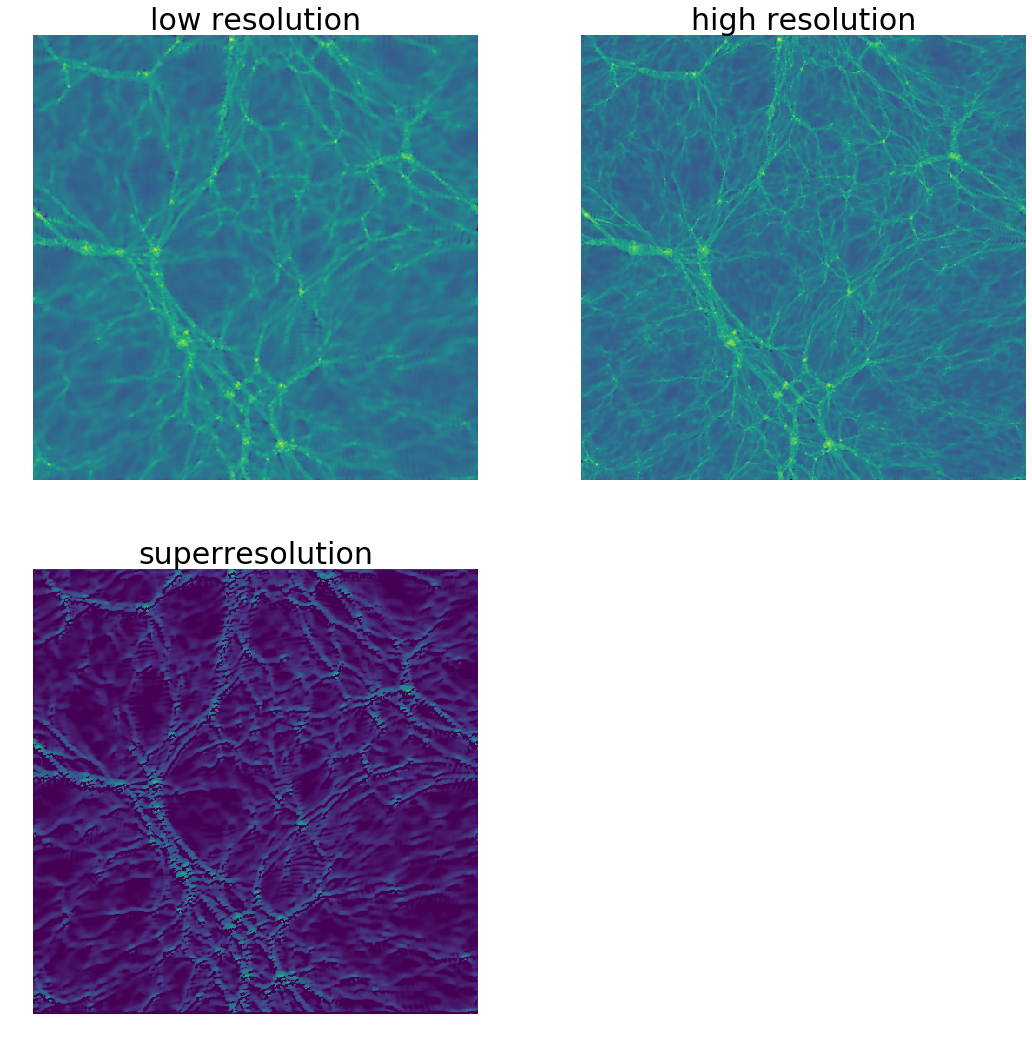

In [20]:
sr_sim = quick_evaluation('/u/ivkos/sr/primitive_gan_av1_scaled/', scale=tranform_avg1, img_scale=transform_exp, model=gan_model)

In [21]:
get_stats(sr_sim)

The maximum of the simulation is 0.009616067633032799
The minimum of the simulation is 0.0
The average of the simulation is 9.345746189839708e-07
The median of the simulation is 8.684726182650593e-08
The standart deviation of the simulation is 1.5379586370196908e-05


In [18]:
get_stats(sim_lr)

The maximum of the simulation is 0.849190890789032
The minimum of the simulation is 0.0
The average of the simulation is 5.6975877669174224e-05
The median of the simulation is 1.3475185369316023e-05
The standart deviation of the simulation is 0.0008925787988118827


In [19]:
get_stats(sim_hr)

The maximum of the simulation is 0.8474966287612915
The minimum of the simulation is 0.0
The average of the simulation is 5.7038483646465465e-05
The median of the simulation is 1.0945202120637987e-05
The standart deviation of the simulation is 0.0009006379987113178
